# GPU -CUDA

**Wykonał: Paweł Kruczkiewicz**

Wykonano w środowisku Google Collab na Tesli T4

## Ćw 1

Kod:

```cpp
/* Copyright (c) 2022, NVIDIA CORPORATION. All rights reserved.
 *
 * Redistribution and use in source and binary forms, with or without
 * modification, are permitted provided that the following conditions
 * are met:
 *  * Redistributions of source code must retain the above copyright
 *    notice, this list of conditions and the following disclaimer.
 *  * Redistributions in binary form must reproduce the above copyright
 *    notice, this list of conditions and the following disclaimer in the
 *    documentation and/or other materials provided with the distribution.
 *  * Neither the name of NVIDIA CORPORATION nor the names of its
 *    contributors may be used to endorse or promote products derived
 *    from this software without specific prior written permission.
 *
 * THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS ``AS IS'' AND ANY
 * EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 * IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
 * PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT OWNER OR
 * CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
 * EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
 * PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
 * PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY
 * OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
 * (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 * OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 */

/**
 * Vector addition: C = A + B.
 *
 * This sample is a very basic sample that implements element by element
 * vector addition. It is the same as the sample illustrating Chapter 2
 * of the programming guide with some additions like error checking.
 */

#include <stdio.h>

// For the CUDA runtime routines (prefixed with "cuda_")
#include <cuda_runtime.h>

#include <helper_cuda.h>
/**
 * CUDA Kernel Device code
 *
 * Computes the vector addition of A and B into C. The 3 vectors have the same
 * number of elements numElements.
 */
__global__ void vectorAdd(const float *A, const float *B, float *C,
                          int numElements) {
  int i = blockDim.x * blockIdx.x + threadIdx.x;

  if (i < numElements) {
    C[i] = A[i] + B[i] + 0.0f;
  }
}

/**
 * Host main routine
 */
int main(void) {
  // Error code to check return values for CUDA calls
  cudaError_t err = cudaSuccess;


  for (int numElements = 10000000; numElements <= 100000000; numElements += 10000000){ 
  

  // CudaEvents for time measurements
	cudaEvent_t start, end;
  cudaEventCreate(&start);
  cudaEventCreate(&end);

  // Print the vector length to be used, and compute its size
  
  size_t size = numElements * sizeof(float);

  // Allocate the host input vector A
  float *h_A = (float *)malloc(size);

  // Allocate the host input vector B
  float *h_B = (float *)malloc(size);

  // Allocate the host output vector C
  float *h_C = (float *)malloc(size);

  // Verify that allocations succeeded
  if (h_A == NULL || h_B == NULL || h_C == NULL) {
    fprintf(stderr, "Failed to allocate host vectors!\n");
    exit(EXIT_FAILURE);
  }

  // Initialize the host input vectors
  for (int i = 0; i < numElements; ++i) {
    h_A[i] = rand() / (float)RAND_MAX;
    h_B[i] = rand() / (float)RAND_MAX;
  }

  // Allocate the device input vector A
  float *d_A = NULL;
  err = cudaMalloc((void **)&d_A, size);

  if (err != cudaSuccess) {
    fprintf(stderr, "Failed to allocate device vector A (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  // Allocate the device input vector B
  float *d_B = NULL;
  err = cudaMalloc((void **)&d_B, size);

  if (err != cudaSuccess) {
    fprintf(stderr, "Failed to allocate device vector B (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  // Allocate the device output vector C
  float *d_C = NULL;
  err = cudaMalloc((void **)&d_C, size);

  if (err != cudaSuccess) {
    fprintf(stderr, "Failed to allocate device vector C (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  // Copy the host input vectors A and B in host memory to the device input
  // vectors in
  // device memory
  err = cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);

  if (err != cudaSuccess) {
    fprintf(stderr,
            "Failed to copy vector A from host to device (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  err = cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

  if (err != cudaSuccess) {
    fprintf(stderr,
            "Failed to copy vector B from host to device (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  // Launch the Vector Add CUDA Kernel
  for (int threadsPerBlock = 16; threadsPerBlock <= 256; threadsPerBlock *= 2){
  int blocksPerGrid = (numElements + threadsPerBlock - 1) / threadsPerBlock;

  for (int i = 0; i < 5; i++){
    cudaEventRecord(start);
    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, numElements);
    cudaEventRecord(end);
    cudaEventSynchronize(end);

    err = cudaGetLastError();

    if (err != cudaSuccess) {
      fprintf(stderr, "Failed to launch vectorAdd kernel (error code %s)!\n",
              cudaGetErrorString(err));
      exit(EXIT_FAILURE);
    }

    // Copy the device result vector in device memory to the host result vector
    // in host memory.
    err = cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    if (err != cudaSuccess) {
      fprintf(stderr,
              "Failed to copy vector C from device to host (error code %s)!\n",
              cudaGetErrorString(err));
      exit(EXIT_FAILURE);
    }

    // Verify that the result vector is correct
    for (int i = 0; i < numElements; ++i) {
      if (fabs(h_A[i] + h_B[i] - h_C[i]) > 1e-5) {
        fprintf(stderr, "Result verification failed at element %d!\n", i);
        exit(EXIT_FAILURE);
      }
    }

    float time = 0;
    cudaEventElapsedTime(&time, start, end);
    printf("%d,%d,%f,%d\n", numElements, threadsPerBlock, time, i);
  }
  }
  // Free device global memory
  err = cudaFree(d_A);

  if (err != cudaSuccess) {
    fprintf(stderr, "Failed to free device vector A (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  err = cudaFree(d_B);

  if (err != cudaSuccess) {
    fprintf(stderr, "Failed to free device vector B (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  err = cudaFree(d_C);

  if (err != cudaSuccess) {
    fprintf(stderr, "Failed to free device vector C (error code %s)!\n",
            cudaGetErrorString(err));
    exit(EXIT_FAILURE);
  }

  // Free host memory
  free(h_A);
  free(h_B);
  free(h_C);
}
  printf("Done\n");
  return 0;
}

```

In [53]:
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [48]:
data = pd.read_csv("data/1.csv")
data.head()


,number_of_elements,threads_per_block,time,iter
0,10000000,16,1.949024,0
1,10000000,16,1.958880,1
2,10000000,16,1.961888,2
3,10000000,16,1.954432,3
4,10000000,16,1.955776,4


[Text(0.5, 0, 'Number of elements'),
 Text(0, 0.5, 'Time [ms]'),
 Text(0.5, 1.0, 'Time per number of elements')]

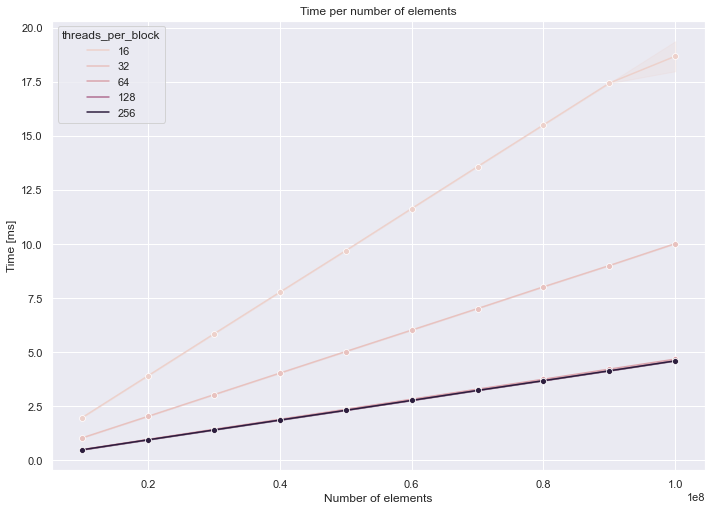

In [56]:
sns.lineplot(data=data, x="number_of_elements", y="time", hue="threads_per_block", marker="o").set(xlabel="Number of elements", ylabel="Time [ms]", title="Time per number of elements")

## Ćw 2

Kod naiwny:

```cpp
%%cu
#include<stdio.h>
#include<stdlib.h>

#define BLOCK_SIZE 32

__global__ void matrix_transpose_naive(int *input, int *output, int n) {

	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;
	int index = indexY * n + indexX;
	int transposedIndex = indexX * n + indexY;

    // this has discoalesced global memory store  
	output[transposedIndex] = input[index];

	// this has discoalesced global memore load
	// output[index] = input[transposedIndex];
}

__global__ void matrix_transpose_shared(int *input, int *output, int n) {

	__shared__ int sharedMemory [BLOCK_SIZE] [BLOCK_SIZE];

	// global index	
	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;

	// transposed global memory index
	int tindexX = threadIdx.x + blockIdx.y * blockDim.x;
	int tindexY = threadIdx.y + blockIdx.x * blockDim.y;

	// local index
	int localIndexX = threadIdx.x;
	int localIndexY = threadIdx.y;

	int index = indexY * n + indexX;
	int transposedIndex = tindexY * n + tindexX;

	// reading from global memory in coalesed manner and performing tanspose in shared memory
	sharedMemory[localIndexX][localIndexY] = input[index];

	__syncthreads();

	// writing into global memory in coalesed fashion via transposed data in shared memory
	output[transposedIndex] = sharedMemory[localIndexY][localIndexX];
}

//basically just fills the array with index.
void fill_array(int *data, int n) {
	for(int idx=0;idx<(n*n);idx++)
		data[idx] = idx;
}

void print_output(int *a, int *b, int n) {
	printf("\n Original Matrix::\n");
	for(int idx=0;idx<(n*n);idx++) {
		if(idx%n == 0)
			printf("\n");
		printf(" %d ",  a[idx]);
	}
	printf("\n Transposed Matrix::\n");
	for(int idx=0;idx<(n*n);idx++) {
		if(idx%n == 0)
			printf("\n");
		printf(" %d ",  b[idx]);
	}
}

int main(void) {
	int *a, *b;
        int *d_a, *d_b; // device copies of a, b, c

	cudaEvent_t start, end;
  cudaEventCreate(&start);
  cudaEventCreate(&end);

  for (int n = 1028; n <= 10280; n += 1028){  
    int size = n * n *sizeof(int);

    // Alloc space for host copies of a, b, c and setup input values
    a = (int *)malloc(size); fill_array(a, n);
    b = (int *)malloc(size);

    // Alloc space for device copies of a, b, c
    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);

    // Copy inputs to device
    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    dim3 blockSize(BLOCK_SIZE,BLOCK_SIZE,1);
    dim3 gridSize(n/BLOCK_SIZE,n/BLOCK_SIZE,1);

    for (int i = 0; i < 5; i++){
    cudaEventRecord(start);
    // matrix_transpose_naive<<<gridSize,blockSize>>>(d_a,d_b,n);
    matrix_transpose_shared<<<gridSize,blockSize>>>(d_a,d_b,n);
    cudaEventRecord(end);
    cudaEventSynchronize(end);

    float time = 0;
    cudaEventElapsedTime(&time, start, end);
    printf("%d,%f,%d\n", n, time, i);
}
    free(a);
    free(b);
      cudaFree(d_a);
    cudaFree(d_b); 
  }

	return 0;
}

```


Kod wykorzystujący pamięć współdzieloną:

```cpp
%%cu
#include<stdio.h>
#include<stdlib.h>

#define BLOCK_SIZE 32

__global__ void matrix_transpose_naive(int *input, int *output, int n) {

	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;
	int index = indexY * n + indexX;
	int transposedIndex = indexX * n + indexY;

    // this has discoalesced global memory store  
	output[transposedIndex] = input[index];

	// this has discoalesced global memore load
	// output[index] = input[transposedIndex];
}

__global__ void matrix_transpose_shared(int *input, int *output, int n) {

	__shared__ int sharedMemory [BLOCK_SIZE] [BLOCK_SIZE];

	// global index	
	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;

	// transposed global memory index
	int tindexX = threadIdx.x + blockIdx.y * blockDim.x;
	int tindexY = threadIdx.y + blockIdx.x * blockDim.y;

	// local index
	int localIndexX = threadIdx.x;
	int localIndexY = threadIdx.y;

	int index = indexY * n + indexX;
	int transposedIndex = tindexY * n + tindexX;

	// reading from global memory in coalesed manner and performing tanspose in shared memory
	sharedMemory[localIndexX][localIndexY] = input[index];

	__syncthreads();

	// writing into global memory in coalesed fashion via transposed data in shared memory
	output[transposedIndex] = sharedMemory[localIndexY][localIndexX];
}

//basically just fills the array with index.
void fill_array(int *data, int n) {
	for(int idx=0;idx<(n*n);idx++)
		data[idx] = idx;
}

void print_output(int *a, int *b, int n) {
	printf("\n Original Matrix::\n");
	for(int idx=0;idx<(n*n);idx++) {
		if(idx%n == 0)
			printf("\n");
		printf(" %d ",  a[idx]);
	}
	printf("\n Transposed Matrix::\n");
	for(int idx=0;idx<(n*n);idx++) {
		if(idx%n == 0)
			printf("\n");
		printf(" %d ",  b[idx]);
	}
}

int main(void) {
	int *a, *b;
        int *d_a, *d_b; // device copies of a, b, c

	cudaEvent_t start, end;
  cudaEventCreate(&start);
  cudaEventCreate(&end);

  for (int n = 1028; n <= 10280; n += 1028){  
    int size = n * n *sizeof(int);

    // Alloc space for host copies of a, b, c and setup input values
    a = (int *)malloc(size); fill_array(a, n);
    b = (int *)malloc(size);

    // Alloc space for device copies of a, b, c
    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);

    // Copy inputs to device
    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    dim3 blockSize(BLOCK_SIZE,BLOCK_SIZE,1);
    dim3 gridSize(n/BLOCK_SIZE,n/BLOCK_SIZE,1);

    for (int i = 0; i < 5; i++){
    cudaEventRecord(start);
    matrix_transpose_naive<<<gridSize,blockSize>>>(d_a,d_b,n);
    // matrix_transpose_shared<<<gridSize,blockSize>>>(d_a,d_b,n);
    cudaEventRecord(end);
    cudaEventSynchronize(end);

    float time = 0;
    cudaEventElapsedTime(&time, start, end);
    printf("%d,%f,%d\n", n, time, i);
}
    free(a);
    free(b);
      cudaFree(d_a);
    cudaFree(d_b); 
  }

	return 0;
}
```


In [70]:
data2 = pd.read_csv("data/2.csv")

<AxesSubplot:title={'center':'Naive vs Shared'}, xlabel='Matrix width and lenght', ylabel='Time [ms]'>

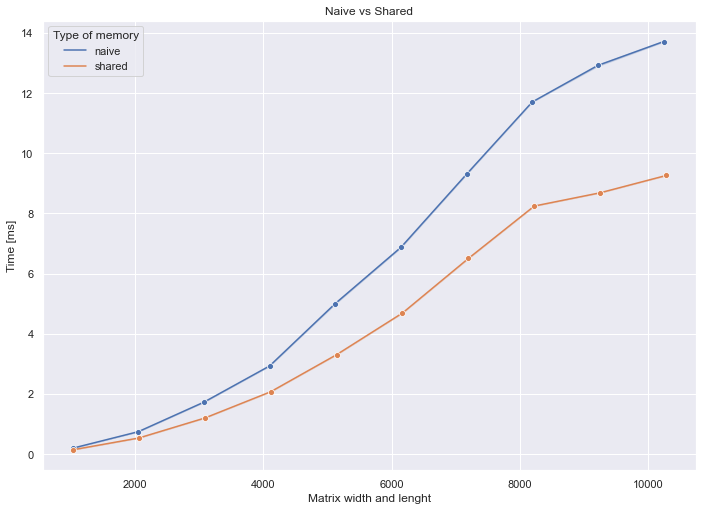

In [71]:
ax = sns.lineplot(data=data2, y="t", x="n", hue="l", marker="o")
ax.set(title="Naive vs Shared", xlabel="Matrix width and lenght", ylabel="Time [ms]")
ax.legend(title="Type of memory")

ax